<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/CNN_Lukas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import datetime
import sklearn
import matplotlib.pyplot as plt
import math
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import lightgbm as lgb
import xgboost as xgb

from seaborn import heatmap
from matplotlib import pyplot as plt

from tensorflow.keras import models, layers, Input

# for  3D CNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical


In [2]:
drive.mount('/content/drive')
data = np.load('/content/drive/MyDrive/Colab Notebooks/Data/train.npz')
public_test_data = np.load('/content/drive/MyDrive/Colab Notebooks/Data/public_test.npz')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# separate bands and labels for train set:
train_data = data['bands']
labels = data['lulc']

In [4]:
train_data.shape

(10000, 12, 33, 33, 6)

In [5]:
labels.shape

(10000,)

In [6]:
# extract bands from train set:
public_bands = public_test_data['bands']

In [7]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])
classes_without_empty_labels=np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Artificial Surface', 'Bareland'])

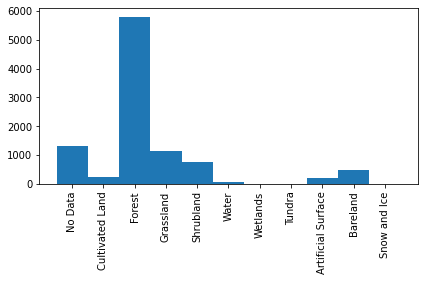

In [8]:
# Class distribution:
plt.hist(labels, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

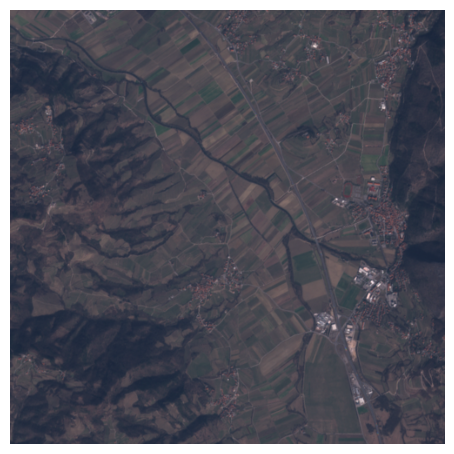

In [11]:
# Plot image:
plt.figure(figsize=(6, 6), dpi=96)
### Load September
band = public_bands[2,:,:,:3]
### Flip from BGR to RGB
band = np.flip(band, -1)
### Change Bridness
band += .3
### Change Contrast
c_fact = 2.5
band = 0.5 + c_fact * (band - 0.5)
### Clip high values
band = band.clip(0,1)

plt.axis('off')
plt.imshow(band, cmap='gray')

In [9]:
# move months to last axis:
train_data_reshaped_a = np.moveaxis(train_data,1,-1)
train_data_reshaped_a.shape

(10000, 33, 33, 6, 12)

In [10]:
# combine month and channel axes:
train_data_reshaped = train_data_reshaped_a.reshape((10000, 33, 33, -1))
train_data_reshaped.shape

(10000, 33, 33, 72)

In [11]:
train_data[42,:,17,17,0:2] #all 12 months, middel pixel, first band for 42nd datapoint

array([[0.1364, 0.0968],
       [0.1083, 0.0727],
       [0.0999, 0.0736],
       [0.0975, 0.0776],
       [0.0881, 0.081 ],
       [0.3102, 0.2783],
       [0.0915, 0.0788],
       [0.483 , 0.4437],
       [0.0841, 0.0598],
       [0.5468, 0.5127],
       [0.124 , 0.0909],
       [0.3235, 0.2791]], dtype=float32)

In [15]:
train_data_reshaped[42,17,17,0:24]

array([0.1364, 0.1083, 0.0999, 0.0975, 0.0881, 0.3102, 0.0915, 0.483 ,
       0.0841, 0.5468, 0.124 , 0.3235, 0.0968, 0.0727, 0.0736, 0.0776,
       0.081 , 0.2783, 0.0788, 0.4437, 0.0598, 0.5127, 0.0909, 0.2791],
      dtype=float32)

# First Attempt

In [40]:
# This model is similar to the VGGNets

model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, input_shape=(33,33,72)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=11, activation = 'softmax'))

model.compile(
  'Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 64)        41536     
_________________________________________________________________
batch_normalization_7 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 33, 33, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)       

In [41]:
history = model.fit(train_data_reshaped, labels, batch_size=32, validation_split=0.2, validation_batch_size=8, epochs=50, shuffle=True)

Epoch 1/50
250/250 [==============================] - 7s 20ms/step - loss: 1.1537 - accuracy: 0.6336 - val_loss: 1.7352 - val_accuracy: 0.5040
Epoch 2/50
250/250 [==============================] - 5s 19ms/step - loss: 0.9600 - accuracy: 0.6805 - val_loss: 1.7210 - val_accuracy: 0.3665
Epoch 3/50
250/250 [==============================] - 5s 19ms/step - loss: 0.8704 - accuracy: 0.7025 - val_loss: 1.3992 - val_accuracy: 0.5580
Epoch 4/50
250/250 [==============================] - 5s 19ms/step - loss: 0.8423 - accuracy: 0.7021 - val_loss: 1.4670 - val_accuracy: 0.5735
Epoch 5/50
250/250 [==============================] - 5s 18ms/step - loss: 0.7995 - accuracy: 0.7130 - val_loss: 1.6090 - val_accuracy: 0.5205
Epoch 6/50
250/250 [==============================] - 5s 19ms/step - loss: 0.7695 - accuracy: 0.7300 - val_loss: 1.5854 - val_accuracy: 0.5585
Epoch 7/50
250/250 [==============================] - 5s 21ms/step - loss: 0.7637 - accuracy: 0.7309 - val_loss: 1.4549 - val_accuracy: 0.5225

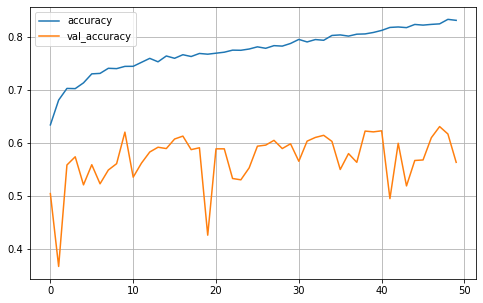

In [49]:
df = pd.DataFrame(history.history)
df[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Second Attempt

In [54]:
# This model is similar to the VGGNet


model2 = models.Sequential()

model2.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation=None, input_shape=(12,33,33,6)))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU()) 
model2.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation=None))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU()) 
model2.add(layers.MaxPooling3D(pool_size=(3, 2, 2), strides=(2, 2, 2)))

model2.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation=None))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU()) 
model2.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation=None))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU()) 
model2.add(layers.MaxPooling3D(pool_size=(3, 2, 2), strides=(2, 2, 2)))

model2.add(layers.Conv3D(filters=256, kernel_size=(3, 3, 3), padding='same', activation=None))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU())
model2.add(layers.Conv3D(filters=256, kernel_size=(3, 3, 3), padding='same', activation=None))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU()) 
model2.add(layers.Conv3D(filters=256, kernel_size=(3, 3, 3), padding='same', activation=None))
model2.add(layers.BatchNormalization())
model2.add(layers.ReLU()) 
model2.add(layers.GlobalAveragePooling3D())

model2.add(layers.Dropout(0.4)) # to prevent overfitting
model2.add(layers.Dense(units=11, activation = 'softmax'))

model2.compile(
  'Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
history2 = model2.fit(train_data[:,:,:,:,:], labels, batch_size=32, validation_split=0.2, validation_batch_size=8, epochs=50, shuffle=True)

In [ ]:
df2 = pd.DataFrame(history2.history)
df2[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Third Attempt:

In [14]:
# Split into train and validation set:
train = {}
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train_data, labels, test_size=0.2, random_state=0)

In [15]:
val = validation['labels']
# train['features'] = to_categorical(train['features'], 11)
train['labels'] = to_categorical(train['labels'], 11)
# validation['features'] = to_categorical(validation['features'], 11)
validation['labels'] = to_categorical(validation['labels'], 11)

In [21]:
model3 = Sequential()
model3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(BatchNormalization(center=True, scale=True))
model3.add(Dropout(0.5))

model3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(BatchNormalization(center=True, scale=True))
model3.add(Dropout(0.5))

model3.add(Flatten())
#model3.add(MaxPooling3D(pool_size=(1, 5, 5)))
model3.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(11, activation='softmax'))

# Compile the model
model3.compile(
    'Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



In [22]:
history3 = model3.fit(train['features'], train['labels'], batch_size=64, epochs=100, validation_data=(validation['features'], validation['labels']))

Epoch 1/100
 27/125 [=====>........................] - ETA: 3s - loss: 1.5781 - accuracy: 0.5428

KeyboardInterrupt: ignored

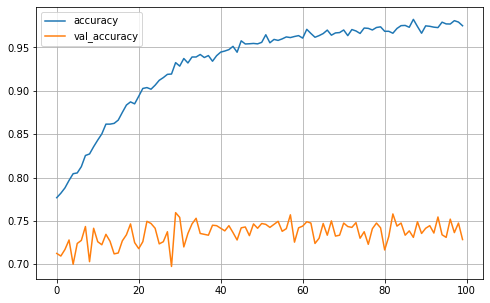

In [52]:
df3 = pd.DataFrame(history3.history)
df3[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Fourth Attempt

In [ ]:
model4 = models.Sequential()

model4.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU()) 
model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU()) 
model4.add(layers.MaxPooling3D(pool_size=(3, 2, 2), strides=(2, 2, 2)))

model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU()) 
model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU()) 
model4.add(layers.MaxPooling3D(pool_size=(3, 2, 2), strides=(2, 2, 2)))

model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU())
model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU()) 
model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(BatchNormalization(center=True, scale=True))
model4.add(layers.ReLU()) 
model4.add(layers.GlobalAveragePooling3D())

model4.add(layers.Dropout(0.4)) # to prevent overfitting
model4.add(Flatten())
model4.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dense(11, activation='softmax'))
model4.add(layers.Dense(units=11, activation = 'softmax'))

model4.compile(
  'Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

model4.summary()

In [ ]:
history4 = model4.fit(train['features'], train['labels'], batch_size=64, epochs=100, validation_data=(validation['features'], validation['labels']))

In [ ]:
df4 = pd.DataFrame(history4.history)
df4[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Attempt five

In [36]:
model5 = Sequential()
model5.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(BatchNormalization(center=True, scale=True))
model5.add(Dropout(0.5))

#model5.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
#model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model5.add(BatchNormalization(center=True, scale=True))
#model5.add(Dropout(0.5))

model5.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model5.add(MaxPooling3D(pool_size=(1, 2, 2)))
model5.add(BatchNormalization(center=True, scale=True))
model5.add(Dropout(0.5))

model5.add(Flatten())
#model5.add(MaxPooling3D(pool_size=(1, 5, 5)))
model5.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model5.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model5.add(Dropout(0.5))

model5.add(Dense(11, activation='softmax'))

# Compile the model
model5.compile(
    'Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [37]:
history5 = model5.fit(train['features'], train['labels'], batch_size=64, epochs=50, validation_data=(validation['features'], validation['labels']))

Epoch 1/25
125/125 [==============================] - 6s 44ms/step - loss: 1.7186 - accuracy: 0.5689 - val_loss: 2.3744 - val_accuracy: 0.5880
Epoch 2/25
125/125 [==============================] - 5s 42ms/step - loss: 1.0324 - accuracy: 0.6606 - val_loss: 1.6543 - val_accuracy: 0.6040
Epoch 3/25
125/125 [==============================] - 5s 42ms/step - loss: 0.9165 - accuracy: 0.6877 - val_loss: 1.5611 - val_accuracy: 0.6150
Epoch 4/25
125/125 [==============================] - 5s 43ms/step - loss: 0.8542 - accuracy: 0.7126 - val_loss: 1.4631 - val_accuracy: 0.6440
Epoch 5/25
125/125 [==============================] - 5s 42ms/step - loss: 0.8047 - accuracy: 0.7287 - val_loss: 1.4560 - val_accuracy: 0.6455
Epoch 6/25
125/125 [==============================] - 5s 42ms/step - loss: 0.7663 - accuracy: 0.7402 - val_loss: 1.0802 - val_accuracy: 0.6715
Epoch 7/25
125/125 [==============================] - 5s 42ms/step - loss: 0.7401 - accuracy: 0.7450 - val_loss: 1.2224 - val_accuracy: 0.6745

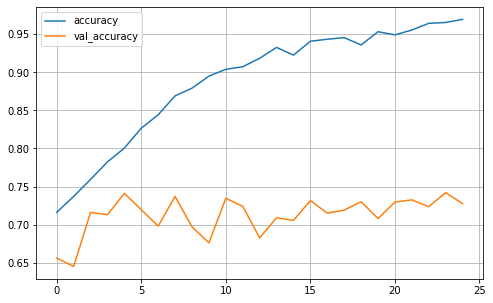

In [32]:
df5 = pd.DataFrame(history5.history)
df5[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()